# Explainable AI for Object Detection with YOLOv8 and EigenCAM

In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██

@File    :   eigencam_yolov8_od.ipynb
@Author  :   Wei Loon Cheng
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   Explainable AI for Object Detection with YOLOv8 and EigenCAM
"""

### Introduction

This notebook serves as an example on how to understand your deep learning object detection model using [EigenCAM](https://arxiv.org/abs/2008.00299). EigenCAM is a gradient-free method that visualizes the principle components of the learned features/representations from the convolutional layers, without the need to modify layers or retrain models.

### Install prerequisites

In [ ]:
%pip install -U datature
%pip install dill
%pip install ttach
%pip install ultralytics
%pip install torch

In [1]:
import os

import cv2
from datature.nexus import Client
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from yolov8_cam.eigen_cam import EigenCAM
from yolov8_cam.utils.image import show_cam_on_image

### Load YOLOv8-Nano Object Detection Model

The sample YOLOv8 model used to show the visualization results in the following cells is a red blood cell detector trained on [Datature Nexus](https://www.datature.io/nexus). We use Datature Python SDK to export the model and download it to the local filesystem.

You can load your own YOLOv8 model trained on Datature Nexus by providing your [project secret key](https://dash.readme.com/project/datature/v1.0/docs/hub-and-api) and modifying the workflow title.

In [ ]:
# Change this to your project secret key to the new project you want to upload your sliced images to
# It can be located on Nexus under the Integrations tab in your project page
SECRET_KEY = "<YOUR_SECRET_KEY"

# Change this to your project ID on Nexus. This can be found via two methods:
# 1. In the URL of the project page (https://nexus.datature.io/project/<YOUR_PROJECT_ID>)
# 2. Project Key in the Integrations page
PROJECT_ID = "proj_<YOUR_PROJECT_ID>"

In [ ]:
client = Client(SECRET_KEY)
project = client.get_project(PROJECT_ID)
workflow_title = "YOUR_WORKFLOW_TITLE"

## Obtain an artifact id from Nexus, in this case, we assume that there is only one artifact
all_artifacts = project.artifacts.list()
artifact = [
    artifact for artifact in all_artifacts
    if artifact["flow_title"] == workflow_title
][-1]
artifact_id = artifact["id"]

# Export a model to the specified model format for specified artifact id
# This function will return an 409 if an export is already in progress,
# or if an export of the same format already exists.
try:
    export_options = {
        "format": "PyTorch"
    }
    project.artifacts.create_export(artifact_id, export_options)
except Exception as err:
    print(err.message)

In [ ]:
# Retrieve model metadata containing the download url
all_models = project.artifacts.list_exported_models(artifact_id)
model_metadata = [
    model for model in all_models if model["format"] == "PyTorch"
][-1]

# Download and unzip the model
model_dir = "./models/"
project.artifacts.download_exported_model(model_metadata["id"], model_dir)

In [ ]:
model_filename = [
    filename for filename in os.listdir(model_dir)
    if filename.endswith("yolov8n.pt")
][-1]
print(model_filename)
model = YOLO(os.path.join(model_dir, model_filename))

In [2]:
# Use the default COCO pretrained model for the following demo
model = YOLO("yolov8m.pt")

### Read and preprocess image

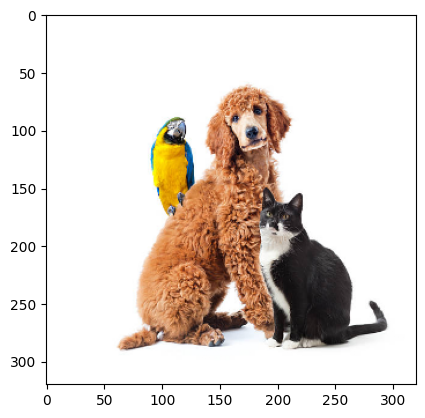

In [3]:
img = cv2.imread('images/bird-dog-cat.jpg')
img = cv2.resize(img, (320, 320))
rgb_img = img.copy()
img = np.float32(img) / 255
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

### Select target layer for feature extraction

Different model architectures tend to utilize different layer activations, so you will need to adjust accordingly if you are using a custom model.

In [4]:
target_layers = [model.model.model[-4]]


0: 640x640 1 bird, 1 cat, 1 dog, 1 frisbee, 390.2ms
Speed: 12.4ms preprocess, 390.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)


principal component 8


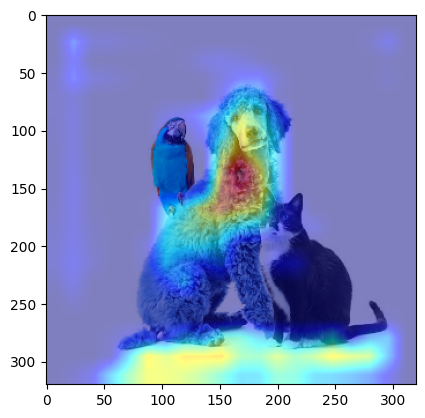

principal component 9


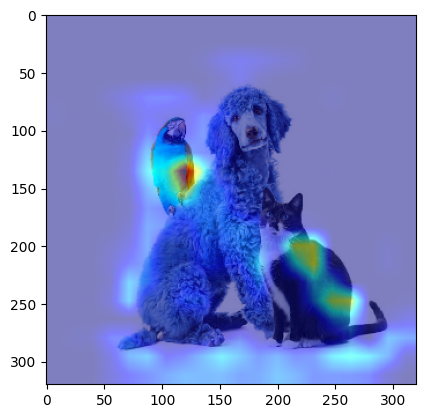

principal component 10


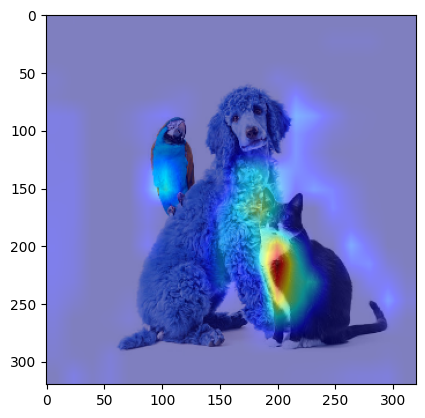

In [5]:
# Select what principal components you want highlighted, zero-indexed
principal_comp = [7,8,9]
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
    principal_comp=principal_comp,
)

for i in range(grayscale_cam.shape[3]):
    cam_image = show_cam_on_image(img, grayscale_cam[0,:,:,i], use_rgb=True)
    print(f"principal component {principal_comp[i]+1}")
    plt.imshow(cam_image)
    plt.show()